In [1]:
import numpy as np
import pandas as pd
import math 
import sys
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [2]:
train_inputs = pd.read_csv("data/train.csv")
X_train = np.array(train_inputs)[:,:-1] 

train_labels = pd.read_csv("data/train_result.csv")
Y_train = np.array(train_labels)[:,1] 

test_inputs = pd.read_csv("data/test.csv")
X_test = np.array(test_inputs)[:,:-1] 

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(50000, 1568)
(50000,)
(10000, 1568)


## Preliminary analysis of data

-Each Image is 1568 feature-long. 
-Each image contains 2 digits.
    - Representing a 56x28 pixel image 

-Each digit is a total of 784 pixel (i.e. 1568/2)
    - Representing a 28x28 pixel image 

    

(1568,)


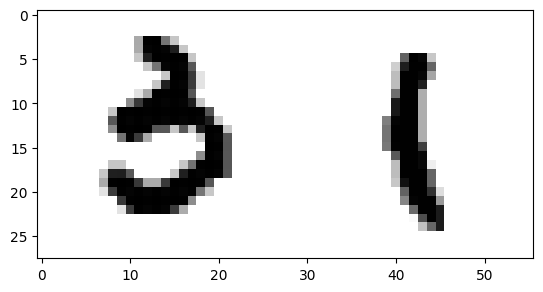

In [3]:
# Try displaying one image 
sampleImage = X_train[1,:]
print(sampleImage.shape)
fig = plt.figure
image = np.reshape(sampleImage, (28,56))
plt.imshow(image, cmap='gray_r')
plt.show()


Overview of label data. 
Labels go from 0 to 18 and we observe a bell-shaped (gaussian-like) distribution.

(50000,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]


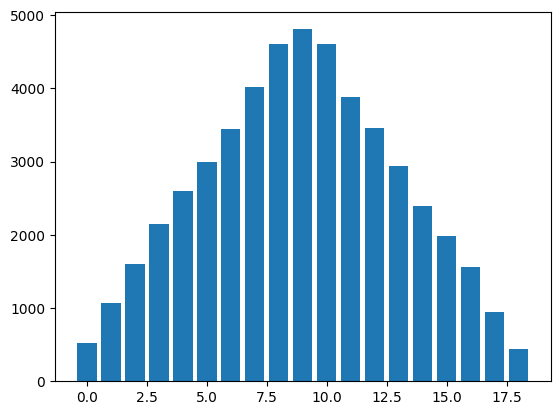

In [24]:
# Class labels summary

# sns.countplot(Y_train)
from collections import Counter
print(Y_train.shape)
print(np.unique(Y_train))
c = Counter(Y_train)
plt.bar(c.keys(), c.values())
plt.show()

## Principal Components analysis (PCA)

Here we will perform a PCA on features to observe relations

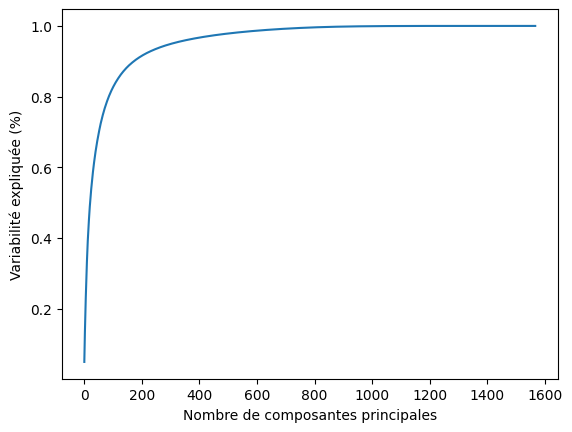

In [5]:
## PCA 
# Centrer les donnees et decomposer en valeurs singulieres
X_train_mean = X_train.mean(0)
centered_X_train = X_train - X_train_mean[np.newaxis, :]

# Décomposition en valeurs singulières
u, s, v = np.linalg.svd(centered_X_train, full_matrices=False)
v = v.T
eig_values = s**2

# Voyons la variabilite explique en fonction du nombre d'axes principaux 
plt.figure()
plt.plot(np.arange(eig_values.shape[0]), np.cumsum(eig_values) / eig_values.sum())
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variabilité expliquée (%)")
plt.show()



C:\Users\othma\AppData\Local\Temp\ipykernel_59588\3097221785.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 50000 + 1) instead
  n=np.random.random_integers(0,Y_train.size)


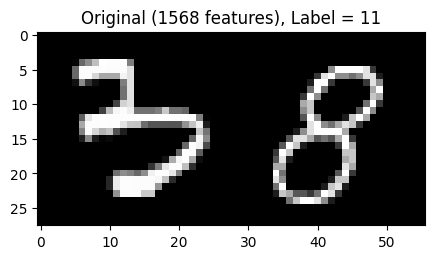

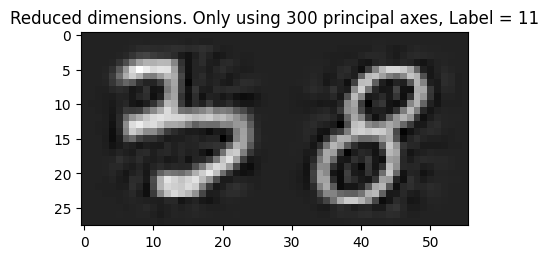

In [6]:
# Visualiser la réduction en j=300 composantes principales (X_hat)
j = 300 
V_j = v[:, :j]
X_hat = (u[:, :j] * s[:j]) @ V_j.T + X_train_mean[np.newaxis, :]
eig_values[:j].sum() / eig_values.sum()
Z_j = centered_X_train@V_j

n=np.random.random_integers(0,Y_train.size)

#Original 
plt.figure(figsize=(5, 5))
plt.title(f'Original (1568 features), Label = {Y_train[n]}')
plt.imshow(X_train[n].reshape((28, 56)), cmap='gray')
plt.show()


# with dimensions reduced
plt.figure(figsize=(5, 5))
plt.title(f'Reduced dimensions. Only using {j} principal axes, Label = {Y_train[n]}')
plt.imshow(X_hat[n].reshape((28, 56)), cmap='gray')
plt.show()

## Logistic Regression

In [77]:
class LogisticRegression : 

    def load_train_data(self, train_inputs, train_labels):
        self.train_inputs=train_inputs
        self.train_labels=train_labels
        self.label_list = np.unique(train_labels)
        self.num_classes = np.unique(train_labels).size
        self.W = None # Weights for logistic regression


    def update_optimization_parameters (self, learnRate, numIterations, mu) : 
        self.learnRate = learnRate
        self.numIterations = numIterations
        self.mu = mu 

    # Stackoverflow suggested solution for one-hot encoding - Source : https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
    @staticmethod
    def get_one_hot(targets, nb_classes):
        # Will return a matrix of one-hot vectors for Y data.
        # The matrix is shape nbTragets x nb_classes (in this case for train data Y_train, 50000 x 19).

        res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
        return res.reshape(list(targets.shape)+[nb_classes])


    @staticmethod
    def softmax(Z):
        #Returns an array with the calculated softmax
        return (np.exp(Z).T / np.sum(np.exp(Z),axis=1)).T 
 

    def cost(self, Y_one_hot, softMaxZ) : 
        # Avg of cross entropies 
        n = Y_one_hot.shape[0]
        return -(np.sum(Y_one_hot * np.log(softMaxZ)))/n  


    def gradientW(self, Y_one_hot, softMaxZ) :
        X = self.train_inputs
        n = X.shape[0]
        return (1/n)*(np.dot(X.T , (softMaxZ - Y_one_hot)))


    def gradientBias(self, Y_one_hot, softMaxZ) :
        n = Y_one_hot.shape[0]
        return (1/n)*(np.sum(softMaxZ - Y_one_hot))

         
    def gradientDescent(self, X, Y, learnRate = 0.2, numIteratitions=200, mu=0.1) : # Minimize cross entropy
        n=X.shape[0]
        self.costArr_grad_descent=[]
        Y_one_hot = self.get_one_hot(np.int_(Y) , self.num_classes)
        
        self.W=np.zeros((X.shape[1], Y_one_hot.shape[1]))
        self.bias= np.random.random(self.num_classes)

        for k in range (numIteratitions):
            # Z = X @ W
            Z = (X @ self.W) + self.bias
            softMaxZ = self.softmax(Z)
            cost = self.cost(Y_one_hot, softMaxZ)
            self.costArr_grad_descent.append(cost)
         
            #new weights 
            gradW = self.gradientW(Y_one_hot, softMaxZ)
            gradB = self.gradientBias(Y_one_hot, softMaxZ)
            self.W -= (learnRate* (gradW + self.W*mu)) # Update in opposite of gradient and consider L2 regularization
            self.bias -= (learnRate*gradB)

            print (f'iteration # {k} of {numIteratitions} ; ({round(k/numIteratitions*100, 2)}%) ; currentCost is {cost}') if k%50 ==0 else None 

        # print(f'Starting cost is  : {self.costArr_grad_descent[0]}. Ending cost is {self.costArr_grad_descent[-1]}')

    def train(self) : 
        X=self.train_inputs
        Y=self.train_labels

        # This will update self.W (weights) with the optimal weights after gradientDescent
        self.gradientDescent(X, Y, self.learnRate, self.numIterations, self.mu)

    
    def compute_predictions(self, X_test) :
        Z = X_test@self.W
        softmaxArr = self.softmax(Z) 

        return np.argmax(softmaxArr,axis=1)


    def split_dataset(train_inputs,train_labels):

        trainIndexes = [k for k in range(train_inputs.shape[0]) if k % 5 in (0,1,2,4) ]
        validationIndexes = [k for k in range(train_inputs.shape[0]) if k % 5 ==3 ]

        trainX = np.array([train_inputs[k] for k in trainIndexes])
        trainY = np.array([train_labels[k] for k in trainIndexes])

        validX = np.array([train_inputs[k] for k in validationIndexes])
        validY = np.array([train_labels[k] for k in validationIndexes])

        return trainX, trainY, validX, validY


    @staticmethod
    def conf_matrix(testlabels, predlabels):
        n_classes = int(max(testlabels)) + 1 # +1 since first class is labeled 0
        matrix = np.zeros((n_classes,n_classes))

        for (test, pred) in zip(testlabels, predlabels):
            matrix[int(test),int(pred)]+=1
        return matrix    

    @staticmethod
    def errorRate (testlabels, predlabels) :
        confmat = LogisticRegression.conf_matrix(testlabels, predlabels)

        # Test error
        sum_total_preds = np.sum(confmat)
        sum_correct_preds = np.sum(np.diag(confmat))
        errorRate = 1.0 - (float(sum_correct_preds) / float(sum_total_preds))
        return errorRate, confmat 
        

In [ ]:
LogisticReg= LogisticRegression()
LogisticReg.load_train_data(X_train, Y_train)
LogisticReg.update_optimization_parameters (learnRate = 0.2, numIterations=300, mu=0.01)
LogisticReg.train()

error rate is 0.77742
Precision is 22.258%


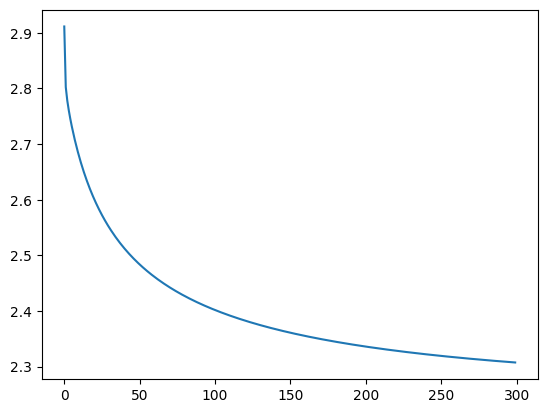

In [64]:
# Analyse du score sur le jeu d'entrainement
Y_pred_on_X_train = LogisticReg.compute_predictions(X_train)
errorRate, confmat = LogisticReg.errorRate(testlabels= Y_train, predlabels=Y_pred_on_X_train)
print(f'error rate is {errorRate}')
print(f'Precision is {np.sum(Y_pred_on_X_train==Y_train)/Y_train.size*100}%')
# print(confmat)

## visualiser la convergence 
plt.figure()
plt.plot(np.arange(len(LogisticReg.costArr_grad_descent)), LogisticReg.costArr_grad_descent)
plt.show()

(50000,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


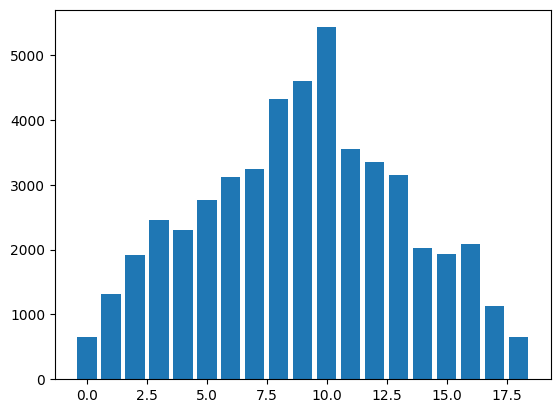

In [24]:
# Distribution of predictions 
from collections import Counter
print(Y_pred_on_X_train.shape)
print(np.unique(Y_pred_on_X_train))
c = Counter(Y_pred_on_X_train)
plt.bar(c.keys(), c.values())
plt.show()

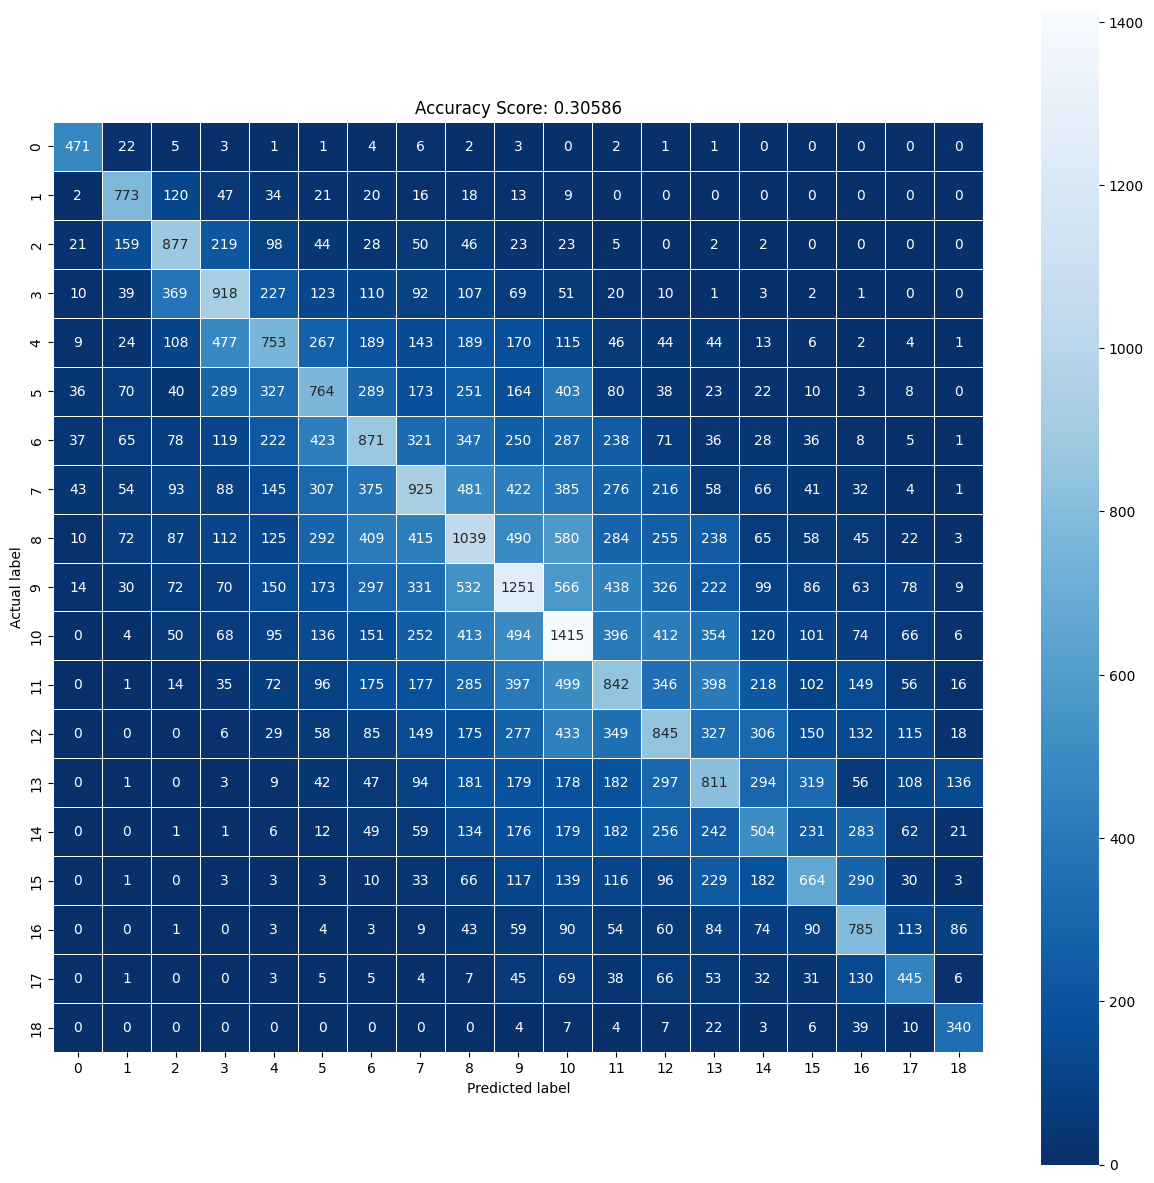

In [25]:
# Show confusion matrix beautified
score = 1-errorRate
plt.figure(figsize=(15,15))
sns.heatmap(confmat, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title);

In [22]:
## Pour soumettre dans le format csv pour Kaggle 
classes_pred_logistic_reg = LogisticReg.compute_predictions(X_test)

indexes = [x for x in range(10000)]
classes = classes_pred_logistic_reg

df = pd.DataFrame({
    'Index': indexes,
    'Class': classes})


df.to_csv("classification_results/predLogisticReg_1.csv",sep=",",index=False)

## Cross validation

In [76]:
# Pour cross-validate 
LogisticReg2 = LogisticRegression()
XTrain, YTrain, Xtest, Ytest = LogisticRegression.split_dataset(X_train, Y_train)
print(XTrain.shape)
print(YTrain.shape)
LogisticReg2.load_train_data(XTrain, YTrain)
LogisticReg2.update_optimization_parameters (learnRate = 0.2, numIterations=100, mu=0.01)
LogisticReg2.train()

# Analyse du score sur le jeu de test
Y_pred_on_X_test = LogisticReg.compute_predictions(Xtest)
errorRate, confmat = LogisticReg.errorRate(testlabels= Ytest, predlabels=Y_pred_on_X_test)
print(f'error rate on test data is {errorRate}')
print(f'Precision on test data is {np.sum(Y_pred_on_X_test==Ytest)/Ytest.size*100}%')


(40000, 1568)
(40000,)
iteration # 0 of 100 ; (0.0%) ; currentCost is 3.0093539138507515
iteration # 10 of 100 ; (10.0%) ; currentCost is 2.6777911985521676
iteration # 20 of 100 ; (20.0%) ; currentCost is 2.6010707208836643
iteration # 30 of 100 ; (30.0%) ; currentCost is 2.5496505444406843
iteration # 40 of 100 ; (40.0%) ; currentCost is 2.512248059707079
iteration # 50 of 100 ; (50.0%) ; currentCost is 2.483528732134275
iteration # 60 of 100 ; (60.0%) ; currentCost is 2.460596168996977
iteration # 70 of 100 ; (70.0%) ; currentCost is 2.44173960275173
iteration # 80 of 100 ; (80.0%) ; currentCost is 2.425883120536441
iteration # 90 of 100 ; (90.0%) ; currentCost is 2.4123142673691746
error rate on test data is 0.7804
Precision on test data is 21.959999999999997%
